# Aufgabe - Rangordnungsoperatoren

Implementieren Sie die naive und die effiziente Version des Median-Operators wie sie im Skript angegeben sind an den mit `#TODO` gekennzeichneten Codestellen.
Beantworten Sie danach die mit `#TODO` gekennzeichneten Fragen.

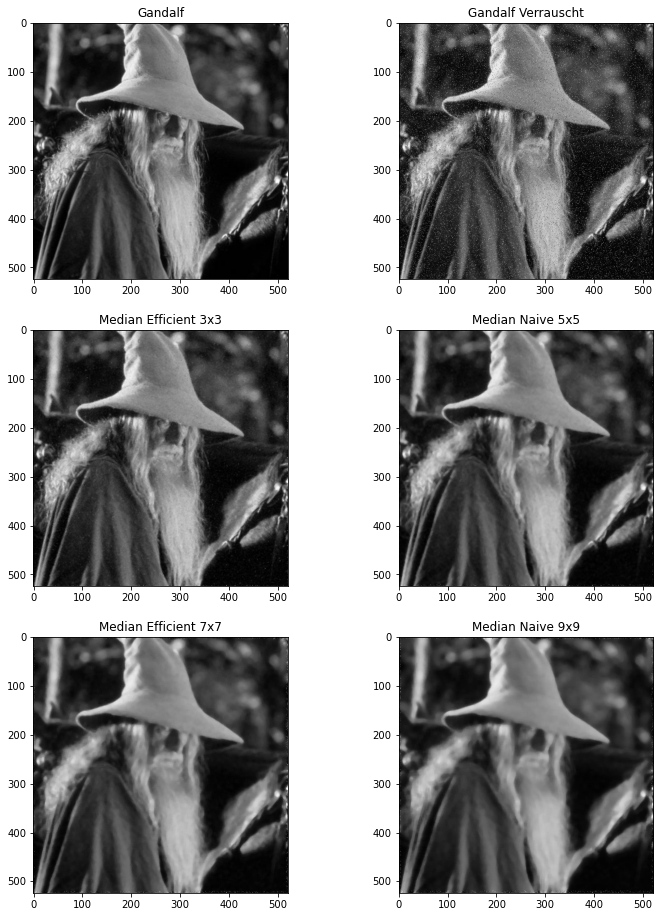

In [4]:
import os

import cv2 as cv
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

def median_naive(img, size):
    if size <= 1 or (size % 2) != 1:
        print('Expected an uneven neighbourhood size larger than 1 e.g. {3, 5, 7, ...}')
        return img
    
    #variable contains the middle point of the flatten array
    centerIndexOfWindowPoints = int(np.floor(size*size/2))
    # the center of the squared window
    shiftFromWindowOrigin = int(np.floor(size/2))
    result = img.copy()
    
    #appling median and sorting of the elements of the window for every possible pixel
    for windowOriginY in range(img.shape[1] - size):
        for windowOriginX in range(img.shape[0] - size):
            windowPoints = img[windowOriginX:(windowOriginX+size), windowOriginY:(windowOriginY+size)].flatten()
            result[windowOriginX + shiftFromWindowOrigin, windowOriginY + shiftFromWindowOrigin] = np.sort(windowPoints)[centerIndexOfWindowPoints]
    
    return result

def median_efficient(img, size):
    if size <= 1 or (size % 2) != 1:
        print('Expected an uneven neighbourhood size larger than 1 e.g. {3, 5, 7, ...}')
        return img
    
    result = img.copy()
    
    #introducing relevant variables
    M = np.power(size,2)
    half = int(np.floor(M/2))
    halfExact = int(np.floor((M+1)/2))
    shiftFromWindowOrigin = int(np.floor(size/2))
                    
    #Iterating through column and restarting the fast median every column. It is maybe
    #more efficient to only start the fast median once in the whole image by applying the algorithm once vertically 
    #for one pixel when the end of a line is reached and then iterating the other direction.
    for windowOriginY in range(img.shape[0] - size):
        grayValueHist = np.zeros(256)
        left = 0
        initHistValues =  img[windowOriginY:windowOriginY + size, 0:size].flatten()
        
        #first time computing the histogram values
        median = np.sort(initHistValues)[half]
        for k in range(len(initHistValues)):
            if median > initHistValues[k]:
                left += 1
            grayValueHist[initHistValues[k]] += 1    
        #appling the algorithm m times.
        for windowOriginX in range(img.shape[1] - size):
            if(windowOriginX != 0):
                valuesAdd = img[windowOriginY:windowOriginY + size, windowOriginX + size -1]
                valuesRemove = img[windowOriginY:windowOriginY + size, windowOriginX - 1]
                for k in range(size):
                    grayValueHist[valuesRemove[k]] -=1
                    if valuesRemove[k] < median:
                        left -= 1
                for k in range(size):
                    grayValueHist[valuesAdd[k]] += 1
                    if valuesAdd[k] < median:
                        left += 1
                if left > half:
                    while left > half:
                        median -= 1
                        left -= grayValueHist[median]
                elif left + grayValueHist[median] < halfExact:
                    while left + grayValueHist[median] < halfExact:
                        left += grayValueHist[median]
                        median += 1
            #applying new median for the center pixel
            result[windowOriginY + shiftFromWindowOrigin,windowOriginX + shiftFromWindowOrigin] = median
                           
                    
    return result
            
    

                    
dir_resources = '../resources'
img_gandalf = cv.imread(os.path.join(dir_resources, 'Gandalf.jpg'), cv.IMREAD_GRAYSCALE)
img_gandalf_noise = cv.imread(os.path.join(dir_resources, 'Gandalf_Noise.jpg'), cv.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(3, 2, figsize = (12, 16))
_ = axs[0, 0].imshow(img_gandalf, cmap='gray')
_ = axs[0, 0].set_title('Gandalf')
_ = axs[0, 1].imshow(img_gandalf_noise, cmap='gray')
_ = axs[0, 1].set_title('Gandalf Verrauscht')
_ = axs[1, 0].imshow(median_efficient(img_gandalf_noise, 3), cmap='gray')
_ = axs[1, 0].set_title('Median Efficient 3x3')
_ = axs[1, 1].imshow(median_naive(img_gandalf_noise, 5), cmap='gray')
_ = axs[1, 1].set_title('Median Naive 5x5')
_ = axs[2, 0].imshow(median_efficient(img_gandalf_noise, 7), cmap='gray')
_ = axs[2, 0].set_title('Median Efficient 7x7')
_ = axs[2, 1].imshow(median_naive(img_gandalf_noise, 9), cmap='gray')
_ = axs[2, 1].set_title('Median Naive 9x9')

### Fragen

* Beschreiben Sie die Unterschiede für verschiedene Nachbarschaftsgrößen und Vergleichen Sie diese mit dem unverrauschtem Bild.

Es kann gesagt werden, dass je größer die Nachbarschaft, desto besser wird das Rauschen eliminiert, aber dadurch werden auch die Knoturen und die Schärfe schlechter. In dem gegeben Beispiel reicht eigentlich schon das 3x3 Fenster um das Rauschen weitestgehend verschwinden zu lassen.  

* Führen Sie die Code-Zelle unten aus, um die Laufzeiten des naiven und effizienten Algorithmus zu vergleichen. Zur Veranschaulichung werden auch die Laufzeiten einer Referenzimplementierung in C++ dargestellt. Interpretieren Sie die Unterschiede.

Beim selbst implementierten schnellen Median erkennt man nur einen linearen Anstieg, was an der Komplexität des Algorithmus liegt.
Beim Naive ist die Median Berechnung eher polynomiell wie man in der naiven c++ Variante erkennen kann. Da C++ code grundsätlich effizienter durch die Hardwarenähe ist bzw. sein kann, sind diese Algorithmen auch schneller. Die effiziente Variante der naiven python implementation scheint auch Effizient zu sein. Das liegt aber nur an der effizienten numpy Implementierung. Es ist klar, dass ab einer bestimmten Größe der naive Algoithmus immer langsamer sein wird als die effiziente Variante. Und das unabhängig von der benutzen Hardware.

In [78]:
import time

def measure_time(func, *args):
    since = time.time()
    func(*args)
    return time.time() - since
    
sizes = np.arange(3, 12, 2)
times_naive = np.array(list(map(lambda size: measure_time(median_naive, img_gandalf_noise, size), sizes)))
times_efficient = np.array(list(map(lambda size: measure_time(median_efficient, img_gandalf_noise, size), sizes)))

sizes_cpp = np.arange(3, 20, 2)
times_naive_cpp     = np.array([0.200, 0.806, 1.686, 3.096, 4.679, 6.558, 9.750, 12.650, 16.219])
times_efficient_cpp = np.array([0.026, 0.038, 0.048, 0.060, 0.064, 0.071, 0.085,  0.099,  0.102])

fig = plt.figure(figsize=(8, 6))
_ = plt.plot(sizes, times_naive, 'go--', label='Naive Median Python')
_ = plt.plot(sizes, times_efficient, 'go-', label='Efficient Median Python')
_ = plt.plot(sizes_cpp, times_naive_cpp, 'ro--', label='Naive Median C++')
_ = plt.plot(sizes_cpp, times_efficient_cpp, 'ro-', label='Efficient Median C++')
_ = plt.xlabel('Neighborhood Size')
_ = plt.ylabel('Time in s')
_ = plt.legend()

### Hinweise

#### Naiver Median
* Mit [slicing](https://numpy.org/doc/stable/reference/arrays.indexing.html) können sie die Nachbarschaft eines Pixels extrahieren.
* Mit der Funktion [ravel]() können sie ein mehrdimensionales Numpy Array in ein eindimensionales überführen
* In Numpy gibt es auch eine Sortierfunktion für Arrays [sort](https://numpy.org/doc/stable/reference/generated/numpy.sort.html) 

#### Effizienter Median
* Orientieren sie sich an dem Pseudocode aus dem Skript

#### Laufzeitunterschiede
* Seien Sie nicht verwundert, wenn der naive Median in Python schneller ist als die effiziente Variante. Wenn Sie mit Numpy arbeiten oder auch von Python bereitgestellte Sortierfunktionen nutzen, wird von Python im Hintergrund effizienter C/C++ Code ausgeführt. Das ist in der Ausführung deutlich schneller als Python-Code (aus dem Ihre effiziente Implementation besteht). Bei sehr großen Nachbarschaftsgrößen sollte der effiziente Median trotzdem schneller sein. Um den Unterschied auch schon bei kleinen Nachbarschaftsgrößen zu verdeutlichen enthält der Code zum Vergleich der Laufzeitunterschiede auch die Zeiten von einer Referenzimplementierung in C++. Dort ist die effiziente Variante auch bei der kleinsten Nachbarschaftsgröße (3x3) schneller als die naive Variante.